In [1]:
import numpy as np
import pandas as pd

import semopy

from IPython.display import Markdown
import networkx as nx
import graphviz as gv

np.random.seed(0)

## 1. サンプルデータ

In [2]:
sample_size = 1000
n_features = 6

#e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, sample_size))
e = np.random.normal(0, 1, size=(n_features, sample_size))
e = pd.DataFrame(e.T, columns=[f"e{i + 1}" for i in range(n_features)])

B = np.array([
    [ 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [ 0.50, 0.00, 0.00, 0.00, 0.00, 0.00],
    [-0.20, 0.00, 0.00, 0.00, 0.00, 0.00],
    [ 0.00,-0.40, 0.00, 0.00, 0.00, 0.00],
    [ 0.00, 0.30, 0.20, 0.00, 0.00, 0.00],
    [ 0.00, 0.00, 0.80, 0.00, 0.00, 0.00],
])

# X = BX + e => X = (I - B)^-1 e
X = np.linalg.pinv(np.eye(n_features) - B) @ e.T

X = pd.DataFrame(X.values.T, columns=[f"x{i + 1}" for i in range(n_features)])

X.shape

(1000, 6)

### 誤差項の分散

In [3]:
e.var()

e1    0.975210
e2    0.938272
e3    0.911250
e4    1.032909
e5    0.996730
e6    0.968403
dtype: float64

### 各変数の分散

In [4]:
X.var()

x1    0.975210
x2    1.151935
x3    0.964469
x4    1.200323
x5    1.112127
x6    1.573965
dtype: float64

### 因果グラフ

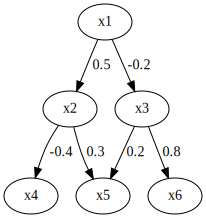

In [5]:
G = nx.from_numpy_array(B.T, create_using=nx.DiGraph)

dot = gv.Digraph()
for from_, to in G.edges:
    dot.edge(f"x{from_ + 1}", f"x{to + 1}", label=f"{B[to, from_]}")
dot

### 方程式

In [6]:
# sympy

## 2. semopy

https://semopy.com/

モデルとして仮定していることやパラメータ名(後に登場するBetaやPsiなど)などが分かるので、[この資料](https://arxiv.org/pdf/2106.01140)を確認しておく。 

ここで使っているモデルは 3.1. の Modelである。

### 推定の例

https://semopy.com/tutorial.html

In [7]:
# 自分で構造を仮定して、与える必要がある。構文は https://semopy.com/syntax.html のページ。
# 構造だけ与える場合は次のようになる。
desc = """
x2 ~ x1
x3 ~ x1
x4 ~ x2
x5 ~ x2 + x3
x6 ~ x3
"""

# モデル作成
model = semopy.Model(desc)

# パラメータの推定(パラメータはpdf参照)
res = model.fit(X)

### モデルの適合度指標

https://www.jstage.jst.go.jp/article/jbhmk/32/2/32_2_209/_article/-char/ja/

In [8]:
stats = semopy.calc_stats(model)
stats

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,10,16,9.722077,0.465206,1021.904715,1.000276,0.990486,0.984778,0.990486,1.000442,0,21.980556,75.965864,0.009722


### 推定結果
詳細はpdfの「9.1 Standard errors and p-values」を参照。opの~は回帰の関係で~~は誤差項の分散・共分散、Estimateが推定値の平均値(パラメータが正規分布することを仮定している)、p値は推定値がゼロである確率。

In [9]:
ins = model.inspect(mode="list")
display(ins)

ins = model.inspect(mode="mx")
for name, values in ins.items():
    display(Markdown("#### " + name))
    display(values)

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,x2,~,x1,0.468839,0.031003,15.122417,0.000000e+00
1,x3,~,x1,-0.236446,0.030548,-7.740226,9.992007e-15
2,x4,~,x2,-0.381686,0.029942,-12.747423,0.000000e+00
3,x5,~,x2,0.267125,0.029546,9.041068,0.000000e+00
4,x5,~,x3,0.223600,0.032285,6.925767,4.336087e-12
5,x6,~,x3,0.792833,0.031685,25.022451,0.000000e+00
6,x2,~~,x2,0.936415,0.041878,22.360680,0.000000e+00
7,x3,~~,x3,0.909117,0.040657,22.360680,0.000000e+00
8,x4,~~,x4,1.031522,0.046131,22.360680,0.000000e+00
9,x5,~~,x5,0.993815,0.044445,22.360680,0.000000e+00


#### Beta

,x1,x2,x3
x1,0.000000,0.0,0.0
x2,0.468839,0.0,0.0
x3,-0.236446,0.0,0.0


#### Lambda

,x1,x2,x3
x4,0.0,-0.381686,0.000000
x5,0.0,0.267125,0.223600
x6,0.0,0.000000,0.792833
x1,1.0,0.000000,0.000000
x2,0.0,1.000000,0.000000
x3,0.0,0.000000,1.000000


#### Psi

,x1,x2,x3
x1,0.974234,0.000000,0.000000
x2,0.000000,0.936415,0.000000
x3,0.000000,0.000000,0.909117


#### Theta

,x4,x5,x6,x1,x2,x3
x4,1.031522,0.000000,0.000000,0.0,0.0,0.0
x5,0.000000,0.993815,0.000000,0.0,0.0,0.0
x6,0.000000,0.000000,0.967371,0.0,0.0,0.0
x1,0.000000,0.000000,0.000000,0.0,0.0,0.0
x2,0.000000,0.000000,0.000000,0.0,0.0,0.0
x3,0.000000,0.000000,0.000000,0.0,0.0,0.0


### 複数のモデルを仮定して適合度指標を比較

In [10]:
stats = []

# 正解と同じ構造だけ与える
desc = """
x2 ~ x1
x3 ~ x1
x4 ~ x2
x5 ~ x2 + x3
x6 ~ x3
"""
model = semopy.Model(desc)
res = model.fit(X)
stats.append(semopy.calc_stats(model))
print("num of estimates:", model.inspect(mode="list").shape[0])

# 正解そのまま
desc = """
x2 ~ 0.5 * x1
x3 ~ -0.2 * x1
x4 ~ -0.4 * x2
x5 ~ 0.3 * x2 + 0.2 * x3
x6 ~ 0.8 * x3
"""
model = semopy.Model(desc)
res = model.fit(X)
stats.append(semopy.calc_stats(model))
print("num of estimates:", model.inspect(mode="list").shape[0])

# データからx1を削除して、x1を潜在変数化。
desc = """
x2 ~ x1
x3 ~ x1
x4 ~ x2
x5 ~ x2 + x3
x6 ~ x3
DEFINE(latent) x1
"""
model = semopy.Model(desc)
res = model.fit(X.drop("x1", axis=1))
stats.append(semopy.calc_stats(model))
print("num of estimates:", model.inspect(mode="list").shape[0])

stats = pd.concat(stats, axis=0)
stats.index = [f"model{i + 1}" for i in range(3)]
stats

num of estimates: 11
num of estimates: 11
num of estimates: 12


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
model1,10,16,9.722077,0.465206,1021.904715,1.000276,0.990486,0.984778,0.990486,1.000442,0.000000,21.980556,75.965864,0.009722
model2,16,16,14.520093,0.560027,1021.904715,1.001471,0.985791,0.985791,0.985791,1.001471,0.000000,9.970960,34.509736,0.014520
model3,3,10,17.604011,0.000531,765.453749,0.980669,0.977002,0.923340,0.977002,0.935562,0.069806,23.964792,82.857855,0.017604


#### メモ：DoFについて

DoFは「k * (k + 1) / 2 - "推定したパラメータ数"」である。"推定したパラメータ数"はmodel.inspect()のうち推定したパラメータの数(Std. errやp-valueが空でない行数)である。

- model1
  - 6 * (6 + 1) / 2 - 11 = 10
- model2
  - 6 * (6 + 1) / 2 - 5 = 16
- model3
  - 5 * (5 + 1) / 2 - 12 = 3

DoF Baselineは全変数が独立であることを仮定したモデル。

- model1
  - 6 * (6 + 1) / 2 - 5 = 16
- model2
  - 6 * (6 + 1) / 2 - 5 = 16
- model3
  - 5 * (5 + 1) / 2 - 12 = 3

#### メモ2：DoFにおけるlavaanとの違い

semopyとlavaanで定義が違うためにDoFの値が違う。設定を変えれば同様の値が出力されるようになる。以下は、https://semopy.com/docs/model.html のDocstringより。

##### mimic_lavaan
pdfの3.1には、インジケータではない出力の観測変数や出力の潜在変数の共分散をパラメータとして推定するかどうかが変わると記載がある。(pdfの図からするとsemopyにおけるoutputな変数とは子を持たない変数のことだと思う)

In [11]:
desc = """
x2 ~ x1
x3 ~ x1
"""

display(Markdown("##### 1. Default(mimic_lavaan=False)"))

model = semopy.Model(desc, mimic_lavaan=False)
res = model.fit(X)
display(semopy.calc_stats(model))
display(model.inspect())

display(Markdown("##### 2. mimic_lavaan=True"))

model = semopy.Model(desc, mimic_lavaan=True)
res = model.fit(X)
display(semopy.calc_stats(model))
display(model.inspect())

##### 1. Default(mimic_lavaan=False)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,2,4,0.003538,0.998232,264.336409,1.007669,0.999987,0.999973,0.999987,1.015338,0,7.999993,27.631014,0.000004


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,x2,~,x1,0.469073,0.031005,15.128964,0.000000e+00
1,x3,~,x1,-0.236131,0.030552,-7.728823,1.088019e-14
2,x2,~~,x2,0.936539,0.041883,22.360680,0.000000e+00
3,x3,~~,x3,0.909373,0.040668,22.360680,0.000000e+00


##### 2. mimic_lavaan=True

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,1,4,0.000321,0.9857,264.336409,1.00384,0.999999,0.999995,0.999999,1.01536,0,9.999999,34.538776,3.212257e-07


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,x2,~,x1,0.469190,0.030999,15.135472,0.000000e+00
1,x3,~,x1,-0.236907,0.030544,-7.756152,8.659740e-15
2,x2,~~,x2,0.936199,0.041868,22.360680,0.000000e+00
3,x2,~~,x3,-0.001863,0.029171,-0.063849,9.490908e-01
4,x3,~~,x3,0.908924,0.040648,22.360680,0.000000e+00
